In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")

In [2]:
prefix = "MAT_big_ATTP_"
filename = "ms_big_attp_filtered_combined.txt"
s = open(filename, "r").readlines()    

In [3]:
raw_pr = []
raw_mem = []
raw_time = []
raw_final_mem = []
ln = 0
query_type = ""
flagFinal = False
for line in s:
    if line.startswith("START_OF_FINAL_STATS_REPORT"):
        flagFinal = True
    if line.startswith("Stats request at line"):
        ln = int(re.findall("\d+", line)[1])
        flagFinal = False
    if line.find(" timers") != -1:
        query_type = line.strip().split(" ")[0]
    if line.find(" ms = ") != -1 and flagFinal:
        t = line.strip().split(':')
        sketch = t[0].split('-')
        sketch = [sketch[0], ''.join(sketch[1:])]
        raw_time.append(sketch + [ln, query_type, int(t[1].split("=")[1].strip()[:-3])])
    if line.find("||ATA-BTB||_2 / ||A||_F^2") != -1:
        t = line.strip().split(':')
        sketch = t[0].split('-')
        sketch = [sketch[0], ''.join(sketch[1:])]
        pr_info = float(t[1].split('=')[-1])
        raw_pr.append(sketch + [pr_info])
    if line.find("MB") != -1:
        t = line.strip().split(':')
        sketch = t[0].split('-')
        t = [sketch[0], ''.join(sketch[1:]), ln, int(t[1].split("=")[0].strip()[:-2])]
        if flagFinal:
            raw_final_mem.append(t)
        else:
            raw_mem.append(t)

In [4]:
mem = pd.DataFrame(raw_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage (B)"])
mem

,Sketch,Param,Stream Size,Memory Usage (B)
0,NORM_SAMPLING,ss10,500,4009216
1,PFD,l200,500,80403440
2,NORM_SAMPLING_WR,ss10,500,3368240
3,NORM_SAMPLING,ss10,1000,4649216
4,PFD,l200,1000,80403440
...,...,...,...,...
2395,NORM_SAMPLING,ss600,50000,262414656
2396,PFD,l40,50000,9440720
2397,PFD,l20,50000,4720416
2398,NORM_SAMPLING_WR,ss600,50000,231318576


In [5]:
final_mem = pd.DataFrame(raw_final_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage (B)"])

In [6]:
time = pd.DataFrame(raw_time, columns = ["Sketch", "Param", "Stream Size", "Type", "Time (ms)"])
time_processed = pd.merge(time, final_mem, on = ["Sketch", "Param", "Stream Size"]).drop(["Stream Size", "Param"], 1).drop_duplicates()
utime = time_processed[time_processed["Type"] == "Update"]
qtime = time_processed[time_processed["Type"] == "Query"]
qtime

,Sketch,Type,Time (ms),Memory Usage (B)
1,NORM_SAMPLING,Query,7515,7769216
3,PFD,Query,1037196,80403440
5,NORM_SAMPLING_WR,Query,8039,6503904
7,NORM_SAMPLING,Query,18024,17535840
9,PFD,Query,637359,60162592
11,NORM_SAMPLING_WR,Query,18455,15068360
13,NORM_SAMPLING,Query,35932,31225856
15,PFD,Query,303433,39921744
17,NORM_SAMPLING_WR,Query,36348,28835872
19,NORM_SAMPLING,Query,70634,57726656


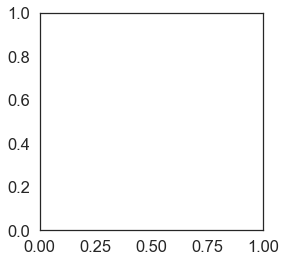

In [8]:
fig, ax = plt.subplots(figsize = (4, 4))
sketch_type = ["NORM_SAMPLING", "NORM_SAMPLING_WR", "PFD"]
sketch_param = {
    "NORM_SAMPLING" : ["ss10", "ss200"],
    "NORM_SAMPLING_WR" : ["ss10", "ss200"],
    "PFD" : ["l10", "l100"],
}
abbrv = {
    "NORM_SAMPLING" : "NS",
    "NORM_SAMPLING_WR" : "NSWR",
    "PFD" : "PFD",    
}
        
linestyles = ["-", "--", "."]
colors = ["r", "g", "b"]
markers = ["o", "x", "^"]
ms = 10
lw = 3

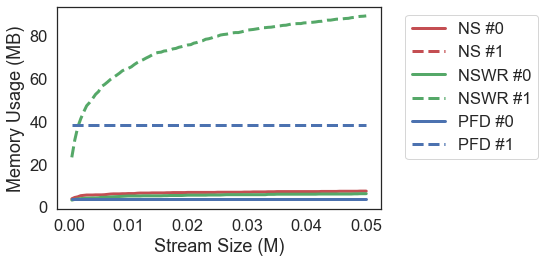

In [9]:
fig, ax = plt.subplots(figsize = (8, 4))
cnt = 0

for sk in sketch_type:
    cnt0 = 0
    for p in sketch_param[sk]:
        dat = mem[(mem["Sketch"] == sk) & (mem["Param"] == p)].sort_values(by = "Stream Size").transpose().to_numpy()
        plt.plot(dat[2] / 1000000.0, dat[3] / 1048576.0, label = "%s #%d" % (abbrv[sk], cnt0), markersize = ms, color = colors[cnt], linestyle = linestyles[cnt0], linewidth = lw)
        cnt0 += 1
    cnt += 1

ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_xlabel("Stream Size (M)")
ax.set_ylabel("Memory Usage (MB)")
plt.tight_layout()
plt.savefig(prefix + 'mem.pdf')

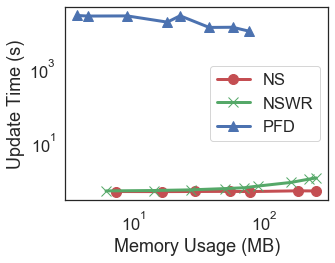

In [10]:
fig, ax = plt.subplots(figsize = (5, 4))
cnt = 0
for sk in sketch_type:
    dat = utime[utime["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[-1] / 1048576.0, dat[-2]/1000.0, color = colors[cnt], marker = markers[cnt], label = abbrv[sk], markersize = ms, linewidth = lw)
    cnt += 1

ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Update Time (s)")
plt.tight_layout()
plt.savefig(prefix + 'utime.pdf')

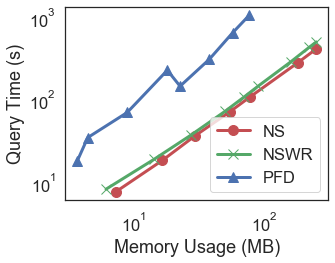

In [11]:
fig, ax = plt.subplots(figsize = (5, 4))
cnt = 0
for sk in sketch_type:
    dat = qtime[qtime["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[-1] / 1048576.0, dat[-2]/1000.0, color = colors[cnt], marker = markers[cnt], label = abbrv[sk], markersize = ms, linewidth = lw)
    cnt += 1

ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Query Time (s)")
plt.tight_layout()
plt.savefig(prefix + 'qtime.pdf')